In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.2MB 81.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/cpi_wdoutResid.csv', index_col=[0], parse_dates=[0])

df.head(2)


,CPI,PC1,RPI,W875RX1,DPCERA3M086SBEA,IPMAT,IPDMAT,S&P 500,S&P: indust,UNRATE,S&P div yield,FEDFUNDS,CP3Mx
date,,,,,,,,,,,,,
1960-02-01,0.001361,-0.252924,0.001145,0.000919,0.004327,-0.013045,-0.016705,-0.039545,-0.043824,-0.4,0.195476,-0.02,-0.25
1960-03-01,0.000000,-0.122290,0.001910,0.000918,0.014072,-0.016548,-0.032085,-0.013719,-0.015046,0.6,0.113782,-0.13,-0.17


In [ ]:
df.shape

In [ ]:

df2 = df.copy()
num_lags = 10 # number of lags and window lenghts for mean aggregation
#delay = 1 # predict target one step ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*+1)
        if column != 'date':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(1).rolling(window=lag+1,center=False).mean()#.shift(1)

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('CPI') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

# the columns in the processed dataframe
df_processed.columns

Index(['CPI', 'CPI_lag1', 'CPI_avg_window_length2', 'CPI_lag2',
       'CPI_avg_window_length3', 'CPI_lag3', 'CPI_avg_window_length4',
       'CPI_lag4', 'CPI_avg_window_length5', 'CPI_lag5',
       ...
       'CP3Mx_lag6', 'CP3Mx_avg_window_length7', 'CP3Mx_lag7',
       'CP3Mx_avg_window_length8', 'CP3Mx_lag8', 'CP3Mx_avg_window_length9',
       'CP3Mx_lag9', 'CP3Mx_avg_window_length10', 'CP3Mx_lag10',
       'CP3Mx_avg_window_length11'],
      dtype='object', length=261)

In [ ]:
# df_processed['date'] = df_processed.index
# df_processed['year'] = df_processed['date'].dt.year
# df_processed['quarter'] = df_processed['date'].dt.quarter
# df_processed['month'] = df_processed['date'].dt.month
# df_processed.head(3)

In [ ]:
# df_processed.to_csv('data.csv')

In [ ]:
X = df_processed.loc[: , 'CPI_lag1' : 'CP3Mx_avg_window_length11'].values
y = df_processed.loc[: ,'CPI'].values

In [ ]:
df_processed.shape

(474, 161)

In [ ]:
# ##  3 step ahead n_splits=10,max_train_size=147 ,test_size=3, gap=0)
# TimeSeriesSplit(n_splits=10,max_train_size=166 ,test_size=1, gap=0)
# tscv = TimeSeriesSplit(n_splits=10,max_train_size=116 ,test_size=6, gap=0)
# TimeSeriesSplit(n_splits=10,max_train_size=167 ,test_size=6, gap=0)
# tscv = TimeSeriesSplit(n_splits=10,max_train_size=147 ,test_size=6, gap=0)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits= 5,max_train_size= 689,test_size= 6, gap=0)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    print("#" * 50)

Train Start: 1 -> End 689
Test Start: 690 -> End 695
##################################################
Train Start: 7 -> End 695
Test Start: 696 -> End 701
##################################################
Train Start: 13 -> End 701
Test Start: 702 -> End 707
##################################################
Train Start: 19 -> End 707
Test Start: 708 -> End 713
##################################################
Train Start: 25 -> End 713
Test Start: 714 -> End 719
##################################################


In [ ]:
df.tail

In [ ]:
test = df_processed.tail(10)
X_test1 = test.loc[: , 'CPI_lag1' : 'CP3Mx_avg_window_length11'].values
                
y_test1 = test.loc[: ,'CPI'].values

In [ ]:
X_test1

In [ ]:
y_test1

In [ ]:
# lgbm = LGBMRegressor()  ## Final for the papers
# lgbm = LGBMRegressor(boosting_type = 'gbdt',

#                 random_state= 87,
#                 num_leaves = 500,
#                 max_bin = 1200,
#                 min_data_in_leaf = 5,
#                 num_boost_round = 1000,
#                 n_estimators = 100,
#                 num_iterations = 2000,
#                 n_jobs = 1,
                
#                 )


# # Create the parameters grid for adaboost:params_ada
# params_lgbm = {'n_estimators':[5000, 10000],'learning_rate':[0.03,0.05,0.10,0.30], 'min_child_samples':[.06,0.08,1.0], 'subsample':[0.6,0.70,0.8,0.9,1.0],\
#                ' reg_alpha':[0 ,0.01,0.001,0.8],' reg_lambda':[0 ,0.01,0.001,0.8,0.9,1.0]}
              
# cv = [(slice(None), slice(None))]   
# # Instantiate a 10-fold CV grid search object:grid_ada
# grid_ada= GridSearchCV(estimator=lgbm,
#                          param_grid= params_lgbm,    
#                          cv=tscv,
#                          scoring="neg_mean_squared_error",
#                          verbose=True,
#                          n_jobs=-1)
# # Fit the combined data to grid_ada 
# grid_ada.fit(X_train, y_train,eval_set=[(X_test1, y_test1)],
#         eval_metric='rmse',
#         early_stopping_rounds= 5);
# # Get the best parameters of the grid search
# grid_ada.best_params_

In [ ]:
grid_ada.best_params_

{' reg_alpha': 0,
 ' reg_lambda': 0,
 'learning_rate': 0.05,
 'min_child_samples': 0.06,
 'n_estimators': 5000,
 'subsample': 0.6}

In [ ]:
# seed 22, for step 6,3,  522 (3 ,1step.) for emp data  Employment_only 

# 80 for 1 automlgt
#80 CAN_USA1_918-2019.csv step 6 , 25 step3 STEP1 80
#step-6  80, step-3, 678 CAN_USA_2004  and (878 step1 lag=5, it worked better)
# step6 192 (191), step 1 ,3 317, 3, 1, 987, Can_US 
# CAN-1981-2019.csv step 1 80,22

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

lgbm = LGBMRegressor()  ## Final for the papers
lgbm = LGBMRegressor(
                random_state= 890,

               num_leaves = 500,
            
               max_bin = 1200,
                min_data_in_leaf = 5,

               num_boost_round = 1000,
               
               n_estimators = 10000,
               num_iterations = 2000,
               n_jobs = 1,

               subsample = 0.8,
               reg_alpha = 0, reg_lambda = 1)


# Create the parameters grid for adaboost:params_ada
params_lgbm = {'n_estimators':[200,500, 1000, 10000],'learning_rate':[0.03,0.05,0.30], 'min_child_samples':[0.01,.06,0.08], 
               'subsample':[0.40, 0.6,0.70,0.80,0.9],  
              'boosting_type':['dart',' gbdt','goss'],
               'num_leaves': sp_randint(6, 50), 
               'max_depth' : [5,6,8,10,15],
               'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
               'reg_alpha':[0 ,0.01],
               'reg_lambda':[0 ,0.01,0.1,1.0]}

# Instantiate a 10-fold CV grid search object:grid_ada
grid_ada_lgbm = RandomizedSearchCV(estimator=lgbm,
                          param_distributions= params_lgbm,    
                         cv=tscv,random_state = 787,         #80
                         scoring="neg_mean_squared_error",
                         verbose=True,
                         n_jobs=-1)
# Fit the combined data to grid_ada 
grid_ada_lgbm.fit(X_train, y_train,eval_set=[(X_test1, y_test1)],
        eval_metric='rmse',
        early_stopping_rounds= 5);
# Get the best parameters of the grid search
grid_ada_lgbm.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 2.10172e-05	valid_0's rmse: 0.00458445
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 2.06276e-05	valid_0's rmse: 0.00454176
[3]	valid_0's l2: 2.0292e-05	valid_0's rmse: 0.00450467
[4]	valid_0's l2: 1.98853e-05	valid_0's rmse: 0.0044593
[5]	valid_0's l2: 1.95174e-05	valid_0's rmse: 0.00441785
[6]	valid_0's l2: 1.92221e-05	valid_0's rmse: 0.0043843
[7]	valid_0's l2: 1.88677e-05	valid_0's rmse: 0.0043437
[8]	valid_0's l2: 1.85529e-05	valid_0's rmse: 0.00430731
[9]	valid_0's l2: 1.82585e-05	valid_0's rmse: 0.004273
[10]	valid_0's l2: 1.80129e-05	valid_0's rmse: 0.00424416
[11]	valid_0's l2: 1.77633e-05	valid_0's rmse: 0.00421465
[12]	valid_0's l2: 1.75246e-05	valid_0's rmse: 0.00418623
[13]	valid_0's l2: 1.73056e-05	valid_0's rmse: 0.00416
[14]	valid_0's l2: 1.70743e-05	valid_0's rmse: 0.00413211
[15]	valid_0's l2: 1.68395e-05	valid_0's rmse: 0.00410359
[16]	valid_0's l2: 1.6643e-05	valid_0's rmse: 0.00407958
[17]	valid_0's l2: 1.64671e-05

{'boosting_type': 'goss',
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 0.08,
 'min_child_weight': 100.0,
 'n_estimators': 200,
 'num_leaves': 43,
 'reg_alpha': 0,
 'reg_lambda': 0.01,
 'subsample': 0.8}

In [ ]:
from math import *
pred = grid_ada_lgbm.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)



0.0037424928817105974


In [ ]:
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
pred_gdp.to_csv('preGDP.csv',index=False)
ActualGDP = df.tail(10).reset_index(drop=False)
actualGDP = ActualGDP[['date','CPI']]
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
forecast = pd.concat([actualGDP, pred_gdp],ignore_index= False, sort=False)
forecast.to_csv('forecas_step-6-ligtGBM.csv')

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_test, y_pred):
    
    def mean_absolute_percentage_error(y_test, y_pred): 
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_test, y_pred)}',end='\n\n')
    
timeseries_evaluation_metrics_func(y_test1,pred)  

Evaluation metric results:-
MSE is : 1.4006252969654492e-05
MAE is : 0.0027224679271378466
RMSE is : 0.0037424928817105974
MAPE is : 117.74353566737292
R2 is : 0.1859250565818409



In [ ]:

# Tuning the XGBoost model
xgbtuned = xgb.XGBRegressor()

# XGBoost

In [ ]:
# seed  22, for six , stepahead, 522 for 3 step, 311 for 1  Employment only
# 79, step-1                                  Employment only
# 80, CAN_USA2004 step6-3
# 22, step6, 3 ,1 Cn_us2019.csv 
# step6-3 80, step1  79, Can_US  (9 step1 lag=5) it worked better


# CAN1981-2019.csv step 1 80,

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV


In [ ]:
xgb = XGBRegressor()  ## Final for the papers
xgb = XGBRegressor(

                random_state= 88,

               num_leaves = 500,
            
               max_bin = 1200,
                min_data_in_leaf = 5,

               num_boost_round = 1000,
               
                num_iterations = 2000,
               n_jobs = 1,

               subsample = 0.8,
               )


# Create the parameters grid for adaboost:params_ada
#params_lgbm = {'n_estimators':[500, 1000, 10000],'learning_rate':[0.03,0.05], 'min_child_samples':[0.01,.06,0.08], 'subsample':[0.6,0.70,1]}

param_grid = {
        'max_depth': [5, 10, 15,20,25],
        'learning_rate': [0.001, 0.03, 0.05, 0.3],
        'subsample': [ 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [ 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.01, 0.5, 1.0, 3.0],
        'gamma': [0 ],
        'tree_method' : ['auto'],
        'grow_policy':['depthwise','lossguide','hist']
,        'n_estimators': [1000, 5000,10000],
         'reg_alpha':[0 ,0.0001,0.01,0.1], 
         'reg_lambda':[0 ,0.001,0.01,0.10, 1.0],
         'normalize_type' :['tree','forest'],
         'sample_type'   :['uniform','weighted'] ,
        'boosting_type' : ['dart','gblinear','gbtree']}              
    
# Instantiate a 10-fold CV grid search object:grid_ada
grid_ada_xgb = RandomizedSearchCV(estimator=xgb,
                          param_distributions = param_grid,    
                         cv=tscv,random_state= 80,               #9898
                         scoring="neg_mean_squared_error",
                         verbose=True,
                         n_jobs=-1)
#grid_ada= GridSearchCV(estimator=xgb,
                       #  param_grid = param_grid,    
                        # cv=tscv,random_state= 89,
                        # scoring="neg_mean_squared_error",
                         #verbose=True,
                         #n_jobs=-1)
# Fit the combined data to grid_ada 
grid_ada_xgb.fit(X_train, y_train,eval_set=[(X_test1, y_test1)],
        eval_metric='rmse',
        early_stopping_rounds= 5);
# Get the best parameters of the grid search
grid_ada_xgb.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [            nan -1.90462800e-05 -3.42826938e-06             nan
             nan -7.67823063e-06             nan -5.31768231e-06
 -2.42700440e-05 -3.47480315e-05]
  category=UserWarning


[00:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.349937
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.245602
[2]	validation_0-rmse:0.17256
[3]	validation_0-rmse:0.121451
[4]	validation_0-rmse:0.085675
[5]	validation_0-rmse:0.060538
[6]	validation_0-rmse:0.042895
[7]	validation_0-rmse:0.030713
[8]	validation_0-rmse:0.021944
[9]	validation_0-rmse:0.015988
[10]	validation_0-rmse:0.011676
[11]	validation_0-rmse:0.008844
[12]	validation_0-rmse:0.007303
[13]	validation_0-rmse:0.005595
[14]	validation_0-rmse:0.004773
[15]	validation_0-rmse:0.004426
[16]	validation_0-rmse:0.004266
[17]	validation_0-rmse:0.003851
[18]	validation_0-rmse:0.003643
[19]	validation_0-rmse:0.003447
[20]	validation_0-rmse:0.003426
[21]	validation_0-rmse:0.003344
[22]	validation_0-rmse:0.003287
[23]	validation_0-rmse:0.003262
[24]	validation_0-rmse:0.003213
[25]	validation_0-rm

{'boosting_type': 'gbtree',
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'grow_policy': 'depthwise',
 'learning_rate': 0.3,
 'max_depth': 15,
 'min_child_weight': 0.5,
 'n_estimators': 10000,
 'normalize_type': 'tree',
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'sample_type': 'uniform',
 'subsample': 0.8,
 'tree_method': 'auto'}

In [ ]:
model = XGBRegressor(
               boosting_type = 'dart',

                random_state= 88,
                  colsample_bylevel = 0.9,
                  colsample_bytree= 0.9,
                  gamma = 0,
                  grow_policy= 'depthwise',
                  learning_rate = 0.3,
                  max_depth = 25,
                  min_child_weight =0.01,
                   n_estimators =1000,
                  normalize_type = 'forest',
                   reg_alpha = 0.01,
                  reg_lambda = 0.01,
                  sample_type = 'weighted',
                  subsample = 0.6,
                  tree_method = 'auto', 
                  num_leaves = 500,              
                   max_bin = 1200,
                    min_data_in_leaf = 5,
                    num_boost_round = 1000,               
                num_iterations = 2000,
               n_jobs = 1,

               )
model.fit(X_train, y_train,eval_set=[(X_test1, y_test1)],
        eval_metric='rmse',
        early_stopping_rounds= 5);

[15:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.85444
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:5.77615
[2]	validation_0-rmse:5.76904
[3]	validation_0-rmse:5.83509
[4]	validation_0-rmse:5.83844
[5]	validation_0-rmse:5.84163
[6]	validation_0-rmse:5.82125
[7]	validation_0-rmse:5.82795
Stopping. Best iteration:
[2]	validation_0-rmse:5.76904



In [ ]:
import math
grid_ada_xgb.predict(X_test1)
# Evaluate and visualize the fit
print("Mean Squared Error: %.6f"
%  math.sqrt(np.mean((grid_ada_xgb.predict(X_test1) - y_test1) ** 2)))
print('Variance Score: %.6f' % grid_ada_xgb.score(X_test1, y_test1))

Mean Squared Error: 6.139034
Variance Score: -37.687738


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = grid_ada_xgb.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)

6.139033975088233


In [ ]:
from math import *
#test =df_processed.tail(11)
#X_test1 = test.loc[: , 'gdpm_lag1' : 'gdpm4']
#y_test1 = test.loc[: ,'gdpm']
pred = grid_ada_xgb.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)

6.139033975088233


In [ ]:
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
pred_gdp.to_csv('preGDP.csv',index=False)
ActualGDP = df.tail(24).reset_index(drop=False)
actualGDP = ActualGDP[['date','GDP']]
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
forecast = pd.concat([actualGDP, pred_gdp],ignore_index= False, sort=False)
forecast.to_csv('forecas_step-3-XGBOOST.csv')


In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_test, y_pred):
    
    def mean_absolute_percentage_error(y_test, y_pred): 
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_test, y_pred)}',end='\n\n')

timeseries_evaluation_metrics_func(y_test1,pred)    

Evaluation metric results:-
MSE is : 0.00039361790802648844
MAE is : 0.006437126241477328
RMSE is : 0.019839806148914067
MAPE is : 4.6506200233687265
R2 is : 0.9941736723578897



# Random_Forest

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
rforest = RandomForestRegressor()

param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500, 750, 1000, 1250, 1500]}



grid_ada_rf= RandomizedSearchCV(estimator=rforest,
                          param_distributions = param_grid,    
                         cv=tscv,random_state= 22,
                         scoring="neg_mean_squared_error",
                         verbose=True,
                         n_jobs=-1)

grid_ada_rf.fit(X_train, y_train,
      
       );
# Get the best parameters of the grid search
grid_ada_rf.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 25,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 750}

In [ ]:
from math import *
#test =df_processed.tail(11)
#X_test1 = test.loc[: , 'gdpm_lag1' : 'gdpm4']
#y_test1 = test.loc[: ,'gdpm']
pred = grid_ada_rf.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)

6.0496425030271475


In [ ]:
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
pred_gdp.to_csv('preGDP.csv',index=False)
ActualGDP = df.tail(24).reset_index(drop=False)
actualGDP = ActualGDP[['date','GDP']]
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
forecast = pd.concat([actualGDP, pred_gdp],ignore_index= False, sort=False)
forecast.to_csv('forecas_step-6_rf.csv')

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_test, y_pred):
    
    def mean_absolute_percentage_error(y_test, y_pred): 
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_test, y_pred)}',end='\n\n')
    
timeseries_evaluation_metrics_func(y_test1,pred)    

Evaluation metric results:-
MSE is : 0.006743485379785086
MAE is : 0.06340420895026316
RMSE is : 0.08211872733904907
MAPE is : 90.06994015280276
R2 is : 0.9001830087726483



# GBM

In [ ]:
gbm = GradientBoostingRegressor()

gbm_param_grid={'n_estimators':[300, 400, 500, 600],
                'learning_rate':[0.03,0.05, 0.1, 0.30],
                'max_depth':[1, 2, 3,5],
                'min_samples_leaf':[1, 2, 3, 4]} 

grid_ada_gbm = RandomizedSearchCV(estimator=gbm,
                          param_distributions = param_grid,    
                         cv=tscv,random_state= 22,
                         scoring="neg_mean_squared_error",
                         verbose=True,
                         n_jobs=-1)

grid_ada_gbm.fit(X_train, y_train    
       );
# Get the best parameters of the grid search
grid_ada_gbm.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
from math import *
#test =df_processed.tail(11)
#X_test1 = test.loc[: , 'gdpm_lag1' : 'gdpm4']
#y_test1 = test.loc[: ,'gdpm']
pred = grid_ada_gbm.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)

0.010971511194418321


In [ ]:
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
pred_gdp.to_csv('preGDP.csv',index=False)
ActualGDP = df.tail(24).reset_index(drop=False)
actualGDP = ActualGDP[['date','GDP']]
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
forecast = pd.concat([actualGDP, pred_gdp],ignore_index= False, sort=False)
forecast.to_csv('forecas_step-3_gbm.csv')

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_test, y_pred):
    
    def mean_absolute_percentage_error(y_test, y_pred): 
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_test, y_pred)}',end='\n\n')
    
timeseries_evaluation_metrics_func(y_test1,pred)  

Evaluation metric results:-
MSE is : 0.00012037405788924655
MAE is : 0.0022395503451577326
RMSE is : 0.010971511194418321
MAPE is : 1.0907009045677007
R2 is : 0.9982182246118083



# Stacking

In [ ]:
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=(grid_ada_lgbm, grid_ada_xgb),
                                meta_regressor= grid_ada_xgb, shuffle = False,
                                cv =tscv,
                                use_features_in_secondary=True)
%time stack.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -0.09278624 -0.13392501         nan         nan -0.11238069
         nan -0.0943272  -0.10408663 -0.09772975]
  category=UserWarning


[20:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -0.08039802 -0.12341963         nan         nan -0.09964708
         nan -0.10082319 -0.0917986  -0.08517132]
  category=UserWarning


[20:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -0.0501275  -0.08614089         nan         nan -0.05651357
         nan -0.0996771  -0.05288049 -0.05032885]
  category=UserWarning


[20:50:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -0.07240868 -0.08444925         nan         nan -0.07202772
         nan -0.10328904 -0.07158453 -0.07247194]
  category=UserWarning


[20:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -0.07243818 -0.08887483         nan         nan -0.07462748
         nan -0.09383384 -0.06964558 -0.07260737]
  category=UserWarning


[21:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -7.43389932 -7.38791607         nan         nan -7.29342684
         nan -7.44032987 -7.15333914 -7.34528894]
  category=UserWarning


[21:16:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -7.42549484 -7.4137861          nan         nan -7.20311136
         nan -6.83168896 -7.15619748 -7.29732838]
  category=UserWarning


[21:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 35s, sys: 3.03 s, total: 7min 38s
Wall time: 1h 11min 39s


StackingCVRegressor(cv=TimeSeriesSplit(gap=0, max_train_size=437, n_splits=5, test_size=6),
                    meta_regressor=RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=437, n_splits=5, test_size=6),
                                                      estimator=XGBRegressor(max_bin=1200,
                                                                             min_data_in_leaf=5,
                                                                             num_boost_round=1000,
                                                                             num_iterations=2000,
                                                                             num_leaves=500,
                                                                             random_state=88,
                                                                             subsample=0.8),
                                                      n_jobs=-1,
                                                    

In [ ]:
from math import *
#test =df_processed.tail(11)
#X_test1 = test.loc[: , 'gdpm_lag1' : 'gdpm4']
#y_test1 = test.loc[: ,'gdpm']
pred = stack.predict(X_test1)
rmse = sqrt(mean_squared_error(y_test1, pred))
print(rmse)

0.12394211683657025


In [ ]:
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
pred_gdp.to_csv('preGDP.csv',index=False)
ActualGDP = df.tail(24).reset_index(drop=False)
actualGDP = ActualGDP[['Date','GDP']]
pred_gdp = pd.DataFrame(pred, columns=['Predicted_gdp'])
forecast = pd.concat([actualGDP, pred_gdp],ignore_index= False, sort=False)
forecast.to_csv('forecas_step-6_stacked.csv')

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_test, y_pred):
    
    def mean_absolute_percentage_error(y_test, y_pred): 
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_test, y_pred)}',end='\n\n')
    
timeseries_evaluation_metrics_func(y_test1,pred)  

Evaluation metric results:-
MSE is : 0.01536164832593003
MAE is : 0.0797743537941138
RMSE is : 0.12394211683657025
MAPE is : 87.37985588995733
R2 is : 0.7726170622711594



# Blending

In [ ]:
def blend_predict(X_test1):
    return ((0.35*grid_ada_lgbm.predict(X_test1)) + (0.25*grid_ada_rf.predict(X_test1)) + \
            (0.25*grid_ada_xgb.predict(X_test1)) + (0.15*grid_ada_gbm.predict(X_test1)) + (np.array(X_test1)))

In [ ]:
test_predict = blend_predict(X_test1)

SHAP-Values

In [ ]:
!pip install shap

In [ ]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [ ]:

explainer = shap.TreeExplainer(model)

In [ ]:
model = grid_ada_xgb.best_estimator_
explainer = shap.TreeExplainer(model)

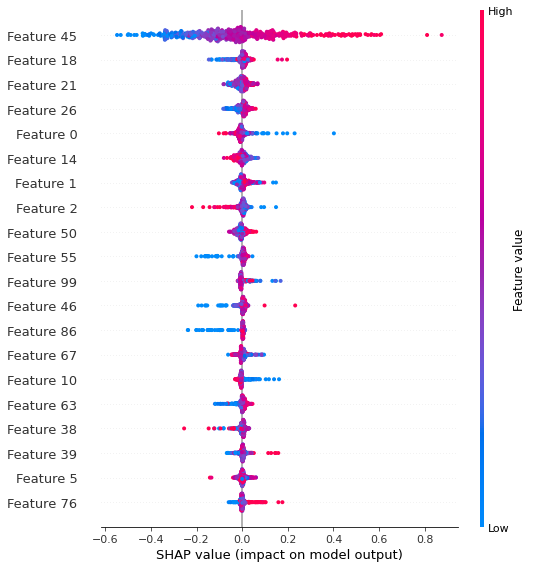

In [ ]:
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
feature_importances = grid_ada_xgb.best_estimator_.feature_importances_

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X)